In [1]:
import pandas as pd
import time
import requests as re
import numpy as np
import csv
import tweepy
import math
import pickle
import json
from nltk import sent_tokenize, word_tokenize
import seaborn as sns
from matplotlib import pyplot as plt
import sys

## Getting Data 

In [2]:
#Loading tweets
twit_arc = pd.read_csv('twitter-archive-enhanced.csv')

#Loading Image Prediction data
tsv_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

with re.Session() as s:
    download = s.get(tsv_url)
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter='\t')
    my_list = list(cr)
    image_predic=pd.DataFrame(my_list[1:], columns = my_list[0])
image_predic.to_csv('image-predictions.tsv')
    

In [3]:
twit_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [4]:
image_predic.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.0614285,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.07419169999999999,True,Rhodesian_ridgeback,0.07201,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.13858399999999998,True,bloodhound,0.11619700000000001,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
image_predic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2075 non-null   object
 1   jpg_url   2075 non-null   object
 2   img_num   2075 non-null   object
 3   p1        2075 non-null   object
 4   p1_conf   2075 non-null   object
 5   p1_dog    2075 non-null   object
 6   p2        2075 non-null   object
 7   p2_conf   2075 non-null   object
 8   p2_dog    2075 non-null   object
 9   p3        2075 non-null   object
 10  p3_conf   2075 non-null   object
 11  p3_dog    2075 non-null   object
dtypes: object(12)
memory usage: 194.7+ KB


In [ ]:
#Defining a function to programmatically link the tweet_id to the json file
def lookup_tweets(tweet_IDs, api):
    full_tweets = []
    tweet_no=0
    for tweet_ID in tweet_IDs:
        tweet_no+=1
        try:
            tweet = api.get_status(id=tweet_ID)._json
            full_tweets.append(tweet)
        except tweepy.TweepError:
            print('No twitter data for ',tweet_ID)
            continue
        if tweet_no%50==0:
            print('Read tweet number ',tweet_no,' which was tweetID ',tweet_ID)
    return full_tweets

consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#Calling the function and storing the data in a DataFrame
list_dict = lookup_tweets((twit_arc['tweet_id']), api)

In [ ]:
#Storing the file in local directory
output_file = open('tweet_json.txt', 'w', encoding='utf-8')
for dic in list_dict:
    json.dump(dic, output_file) 
    output_file.write("\n") #Writing each dictionary in one line

In [6]:
#Reading the file once 
dict_list = []
with open('tweet_json.txt', 'r', encoding='utf8') as f:
    lines = f.read().split('\n')
    for line in lines:
        try:
            data = json.loads(line)
            tweet_data = {
                'tweet_id': str(data['id_str']),
                'text': str(data['text']),
                'favorites': int(data['favorite_count']),
                'retweets': int(data['retweet_count']), 
                'favorited': str(data['favorited']),
                'retweeted': str(data['retweeted'])
            }
            dict_list.append(tweet_data)
        except json.JSONDecodeError:
            print(line)
            continue
json_text = pd.DataFrame(dict_list)       

In [7]:
json_text.head()

,tweet_id,text,favorites,retweets,favorited,retweeted
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,34953,7334,False,False
1,892177421306343426,This is Tilly. She's just checking pup on you....,30267,5473,False,False
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22776,3620,False,False
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38231,7524,False,False
4,891327558926688256,This is Franklin. He would like you to stop ca...,36493,8095,False,False


## Assess

### twit_arc 

Assessing the `.csv` file here

In [8]:
twit_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [9]:
twit_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
twit_arc.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [11]:
twit_arc['name'].value_counts()

None        745
a            55
Charlie      12
Lucy         11
Cooper       11
           ... 
Emma          1
Dook          1
Simba         1
Napolean      1
Grizzie       1
Name: name, Length: 957, dtype: int64

In [12]:
twit_arc['tweet_id'].value_counts()

700151421916807169    1
674764817387900928    1
794926597468000259    1
701570477911896070    1
715220193576927233    1
                     ..
674742531037511680    1
756651752796094464    1
743545585370791937    1
770655142660169732    1
749075273010798592    1
Name: tweet_id, Length: 2356, dtype: int64

In [13]:
twit_arc.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [14]:
twit_arc.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [15]:
twit_arc['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [16]:
twit_arc['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [17]:
twit_arc['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [18]:
twit_arc['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

#### Quality 

- `tweet_id` is of type integer
- `in_reply_to_status_id` is of type integer
- `in_reply_to_user_id` is of type integer
- `retweeted_status_id` is of type integer
- `retweeted_status_user_id` is of type integer
- There are about 55 line items with the `name` as a
- There are 745 line items with the `name` as None
- Not all dogs are categorised as specific dog stages
- There are 25 tweet IDs for which there is no data
- Timestamp is of type string
- There are retweets and replies
- Not all dogs have dog stages. The naming is inconsistent.

#### Tidiness 

- `doggo`, `floofer`, `pupper` & `puppo` are separate columns
- Additional Twitter data is in a separate dictionary

### image_predic

Assessing the `.tsv` file here

In [19]:
image_predic.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.0614285,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.07419169999999999,True,Rhodesian_ridgeback,0.07201,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.13858399999999998,True,bloodhound,0.11619700000000001,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [20]:
image_predic.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.22576999999999997,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.17027799999999998,False,Labrador_retriever,0.16808599999999999,True,spatula,0.0408359,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.0313789,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.0906465,True,papillon,0.0689569,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.09704860000000001,False,bagel,0.08585110000000001,False,banana,0.07611,False


In [21]:
image_predic['tweet_id'].value_counts()

786036967502913536    1
775364825476165632    1
878281511006478336    1
811985624773361665    1
676936541936185344    1
                     ..
838476387338051585    1
682638830361513985    1
813202720496779264    1
692568918515392513    1
708109389455101952    1
Name: tweet_id, Length: 2075, dtype: int64

In [22]:
image_predic.describe()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
count,2075,2075,2075,2075,2075,2075,2075,2075,2075,2075,2075,2075
unique,2075,2009,4,378,2006,2,405,2004,2,408,2006,2
top,786036967502913536,https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg,1,golden_retriever,0.735163,True,Labrador_retriever,0.0693617,True,Labrador_retriever,0.0233535,True
freq,1,2,1780,150,2,1532,104,3,1553,79,2,1499


In [23]:
image_predic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2075 non-null   object
 1   jpg_url   2075 non-null   object
 2   img_num   2075 non-null   object
 3   p1        2075 non-null   object
 4   p1_conf   2075 non-null   object
 5   p1_dog    2075 non-null   object
 6   p2        2075 non-null   object
 7   p2_conf   2075 non-null   object
 8   p2_dog    2075 non-null   object
 9   p3        2075 non-null   object
 10  p3_conf   2075 non-null   object
 11  p3_dog    2075 non-null   object
dtypes: object(12)
memory usage: 194.7+ KB


In [24]:
image_predic['p1'].value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
starfish                1
grey_fox                1
king_penguin            1
pillow                  1
Japanese_spaniel        1
Name: p1, Length: 378, dtype: int64

In [25]:
image_predic['p2'].value_counts()

Labrador_retriever      104
golden_retriever         92
Cardigan                 73
Chihuahua                44
Pomeranian               42
                       ... 
saltshaker                1
Bernese_mountain_dog      1
tray                      1
seashore                  1
Japanese_spaniel          1
Name: p2, Length: 405, dtype: int64

In [26]:
image_predic['p3'].value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
passenger_car          1
can_opener             1
hatchet                1
French_horn            1
rapeseed               1
Name: p3, Length: 408, dtype: int64

#### Quality

- `p1_conf` is of type string
- `p2_conf` is of type string
- `p3_conf` is of type string
- `img_num` is of type string

#### Tidiness

- `p1`, `p2` and `p3` are three different columns
- `p1_conf`, `p2_conf` and `p3_conf` are three different columns
- `p1_dog`, `p2_dog` and `p3_dog` are three different columns

## Clean 

In [27]:
#Creating a copy of the orginal DataFrames
twit_arc_copy = twit_arc.copy()
image_predic_copy = image_predic.copy()

### Incorrect Data Types

twit_arc_copy
- `tweet_id` is of type integer
- `in_reply_to_status_id` is of type integer
- `in_reply_to_user_id` is of type integer
- `retweeted_status_id` is of type integer
- `retweeted_status_user_id` is of type integer
- `retweeted_status_timestamp` is of type string

image_predic
- `p1_conf` is of type string
- `p2_conf` is of type string
- `p3_conf` is of type string
- `img_num` is of type string

##### Define 

Convert:
- `tweet_id` to string
- `in_reply_to_status_id` to string
- `in_reply_to_user_id` to string
- `p1_conf`, `p2_conf`, `p3_conf` to float
- `img_num` to int

##### Code 

In [28]:
twit_arc_copy['tweet_id'] = twit_arc_copy['tweet_id'].astype(str)
twit_arc_copy['in_reply_to_status_id'] = twit_arc_copy['in_reply_to_status_id'].astype(str)
twit_arc_copy['in_reply_to_user_id'] = twit_arc_copy['in_reply_to_user_id'].astype(str)

image_predic_copy['p1_conf'] = image_predic_copy['p1_conf'].astype(float)
image_predic_copy['p2_conf'] = image_predic_copy['p2_conf'].astype(float)
image_predic_copy['p3_conf'] = image_predic_copy['p3_conf'].astype(float)
image_predic_copy['img_num'] = image_predic_copy['img_num'].astype(int)
image_predic_copy['p1_dog'] = image_predic_copy['p1_dog'].astype(bool)
image_predic_copy['p2_dog'] = image_predic_copy['p2_dog'].astype(bool)
image_predic_copy['p3_dog'] = image_predic_copy['p3_dog'].astype(bool)

##### Test 

In [29]:
twit_arc_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   object 
 1   in_reply_to_status_id       2356 non-null   object 
 2   in_reply_to_user_id         2356 non-null   object 
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [30]:
image_predic_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int32  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int32(1), object(5)
memory usage: 144.0+ KB


### Missing Data 

- There are about 55 line items with the name as a  
- There are 745 line items with the name as None
- The favorites and retweets are not pulled in correctly

##### Define 

Get name of the dog from the tweet

##### Code 

In [31]:
twit_arc_copy['text'][0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [32]:
def get_names(sent):    
    try:    
        names = [word
                 for sent in sent_tokenize(sent)
                 for word in word_tokenize(sent)[1:]
                 if (word[0].isupper() and len(word)>1)]
        return names[0]
    except:
        return np.nan

twit_arc_copy['name'] = twit_arc_copy['text'].apply(lambda x: get_names(x))


##### Test 

In [33]:
twit_arc_copy['name'].value_counts()

This        94
Meet        18
Charlie     11
Lucy        11
Oliver      11
            ..
Lulu         1
Marshall     1
Henry        1
Kirk         1
Grizzie      1
Name: name, Length: 1212, dtype: int64

In [34]:
twit_arc['name'].value_counts()

None        745
a            55
Charlie      12
Lucy         11
Cooper       11
           ... 
Emma          1
Dook          1
Simba         1
Napolean      1
Grizzie       1
Name: name, Length: 957, dtype: int64

Although, we did not get the name of every single dog, we did manage to get 200 more than the orginal dataset

### Extra Data

- Merge the twitter API data with the `twit_arc`
- There are retweets and replies
- There are tweets for which there is no data through Twitter API

###### Define 

Join the new twitter file stired as `list_dict` with the `twit_arc` dataframe

###### Code 

In [35]:
json_text.head()

,tweet_id,text,favorites,retweets,favorited,retweeted
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,34953,7334,False,False
1,892177421306343426,This is Tilly. She's just checking pup on you....,30267,5473,False,False
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,22776,3620,False,False
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,38231,7524,False,False
4,891327558926688256,This is Franklin. He would like you to stop ca...,36493,8095,False,False


In [36]:
json_text['tweet_id'] = json_text['tweet_id'].apply(lambda x: str(x))
twit_arc_copy=twit_arc_copy.merge(json_text, how='inner',on='tweet_id')

###### Test 

In [37]:
twit_arc_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2331 non-null   object 
 1   in_reply_to_status_id       2331 non-null   object 
 2   in_reply_to_user_id         2331 non-null   object 
 3   timestamp                   2331 non-null   object 
 4   source                      2331 non-null   object 
 5   text_x                      2331 non-null   object 
 6   retweeted_status_id         163 non-null    float64
 7   retweeted_status_user_id    163 non-null    float64
 8   retweeted_status_timestamp  163 non-null    object 
 9   expanded_urls               2272 non-null   object 
 10  rating_numerator            2331 non-null   int64  
 11  rating_denominator          2331 non-null   int64  
 12  name                        1860 non-null   object 
 13  doggo                       2331 

##### Define 

Remove retweets and replies where the `in_reply_to_status_id` and `retweeted_status_id` is not null

##### Code 

In [38]:
twit_arc_copy = twit_arc_copy[(twit_arc_copy['in_reply_to_status_id']!=np.nan)|(twit_arc_copy['retweeted_status_id']!=np.nan)]
twit_arc_copy.reset_index(drop=True, inplace=True)

##### Test

In [39]:
twit_arc_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2331 non-null   object 
 1   in_reply_to_status_id       2331 non-null   object 
 2   in_reply_to_user_id         2331 non-null   object 
 3   timestamp                   2331 non-null   object 
 4   source                      2331 non-null   object 
 5   text_x                      2331 non-null   object 
 6   retweeted_status_id         163 non-null    float64
 7   retweeted_status_user_id    163 non-null    float64
 8   retweeted_status_timestamp  163 non-null    object 
 9   expanded_urls               2272 non-null   object 
 10  rating_numerator            2331 non-null   int64  
 11  rating_denominator          2331 non-null   int64  
 12  name                        1860 non-null   object 
 13  doggo                       2331 

### Tidiness

###### Define 

Following are the issues:
- `doggo`, `floofer`, `pupper` & `puppo` are separate columns
- `p1`, `p2` and `p3` are three different columns
- `p1_conf`, `p2_conf` and `p3_conf` are three different columns
- `p1_dog`, `p2_dog` and `p3_dog` are three different columns
- `twit_arc` Contains columns with links


Transform `doggo`, `floofer`, `pupper` & `puppo` columns into one column `dog_stage`

###### Code 

In [40]:
def pupper(row):
    if row['doggo']=='doggo':
        return 'doggo'
    elif row['floofer']=='floofer':
        return 'floofer'
    elif row['pupper']=='pupper':
        return 'pupper'
    elif row['puppo']=='puppo':
        return 'puppo'
    else:
        return np.nan

twit_arc_copy['dog_stage'] = twit_arc_copy.apply(lambda x: pupper(x), axis=1)
    

###### Test 

In [41]:
twit_arc_copy['dog_stage'].value_counts()

pupper     243
doggo       94
puppo       29
floofer      9
Name: dog_stage, dtype: int64

###### Define 

Keep only relevant columns for `twit_arc_copy`

###### Code 

In [42]:
twit_arc_copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text_x', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'text_y', 'favorites', 'retweets', 'favorited', 'retweeted',
       'dog_stage'],
      dtype='object')

In [43]:
twit_arc_copy = twit_arc_copy[['tweet_id', 'timestamp', 'text_x', 'rating_numerator', 'rating_denominator',
                               'name', 'dog_stage','retweets', 'favorites']]

###### Test 

In [44]:
twit_arc_copy.head()

,tweet_id,timestamp,text_x,rating_numerator,rating_denominator,name,dog_stage,retweets,favorites
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,7334,34953
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,5473,30267
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,3620,22776
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,7524,38231
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,8095,36493


###### Define 

Have only top confidence level picture with `p#_dog` as True and extract their `p#_og`

In [45]:
image_predic_copy.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


###### Code 

In [46]:
image_predic_copy[image_predic_copy['p1_conf']<image_predic_copy['p2_conf']]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [47]:
image_predic_copy[image_predic_copy['p2_conf']<image_predic_copy['p3_conf']]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


We see that there are no instances of `p2_conf` being greater than `p1_conf` or `p3_conf` being greater than `p2_conf`. Safe to assume that to extract dog name, we need the highest confidence level with `p#_dog` as True

In [48]:
def confidence_def(row):
    if row['p1_dog'] == True and row['p1']!='web_site' and row['p1']!='dishwasher':
        return row['p1']
    else:
        if row['p2_dog'] == True and row['p2']!='web_site' and row['p2']!='dishwasher':
            return row['p2']
        else:
            return row['p3']

image_predic_copy['dog_type'] = image_predic_copy.apply(lambda x: confidence_def(x), axis=1)

###### Test 

In [49]:
image_predic_copy.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,dog_type
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher


###### Define 

Keep only relevant image_predic_copy columns

###### Code 

In [50]:
image_predic_clean = image_predic_copy[['tweet_id', 'dog_type']]

###### Test 

In [51]:
image_predic_clean.head()

,tweet_id,dog_type
0,666020888022790149,Welsh_springer_spaniel
1,666029285002620928,redbone
2,666033412701032449,German_shepherd
3,666044226329800704,Rhodesian_ridgeback
4,666049248165822465,miniature_pinscher


## Merging and Final Dataset

###### Define 

Since the `image_predic_clean` has only the `dog_type` as part of its column, I'm going to join it with the `twit_arc_copy` so that all the data is in one place

###### Code 

In [52]:
merged_df = pd.merge(twit_arc_copy, image_predic_clean, left_on='tweet_id', right_on='tweet_id')

###### Test 

In [53]:
merged_df.head()

,tweet_id,timestamp,text_x,rating_numerator,rating_denominator,name,dog_stage,retweets,favorites,dog_type
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,7334,34953,orange
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,5473,30267,Chihuahua
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,3620,22776,Chihuahua
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,7524,38231,paper_towel
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,8095,36493,basset


In [54]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2059 non-null   object
 1   timestamp           2059 non-null   object
 2   text_x              2059 non-null   object
 3   rating_numerator    2059 non-null   int64 
 4   rating_denominator  2059 non-null   int64 
 5   name                1668 non-null   object
 6   dog_stage           318 non-null    object
 7   retweets            2059 non-null   int64 
 8   favorites           2059 non-null   int64 
 9   dog_type            2059 non-null   object
dtypes: int64(4), object(6)
memory usage: 176.9+ KB


In [55]:
merged_df.to_csv('twitter_archive_master.csv', encoding='utf8')

## Analysis 

Since the number of tweets for each dog type or dog stage can skew the results when taking the average of retweets and favorites, I have taken into consideration only the dog_stage and dog_type which have more than 10 tweets

''

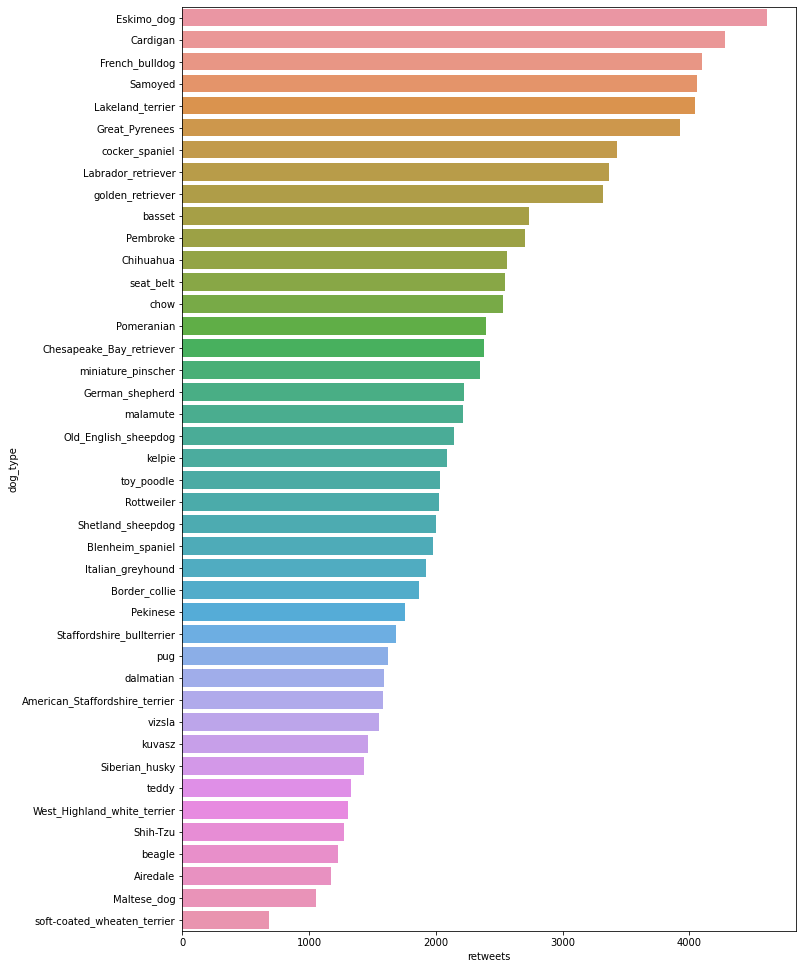

In [56]:
grouped = merged_df.groupby('dog_type').agg({'retweets': 'mean',
                                             'favorites': 'mean',
                                             'tweet_id': 'count'}).reset_index().sort_values('retweets', ascending=False)
fig,g = plt.subplots(figsize=(11,17))
g = sns.barplot(x=grouped[grouped['tweet_id']>10]['retweets'], y=grouped[grouped['tweet_id']>10]['dog_type'])
;

The top three dog types that were retweeted the most were:
- Eskimo Dog
- Cardigan
- French Bulldog

''

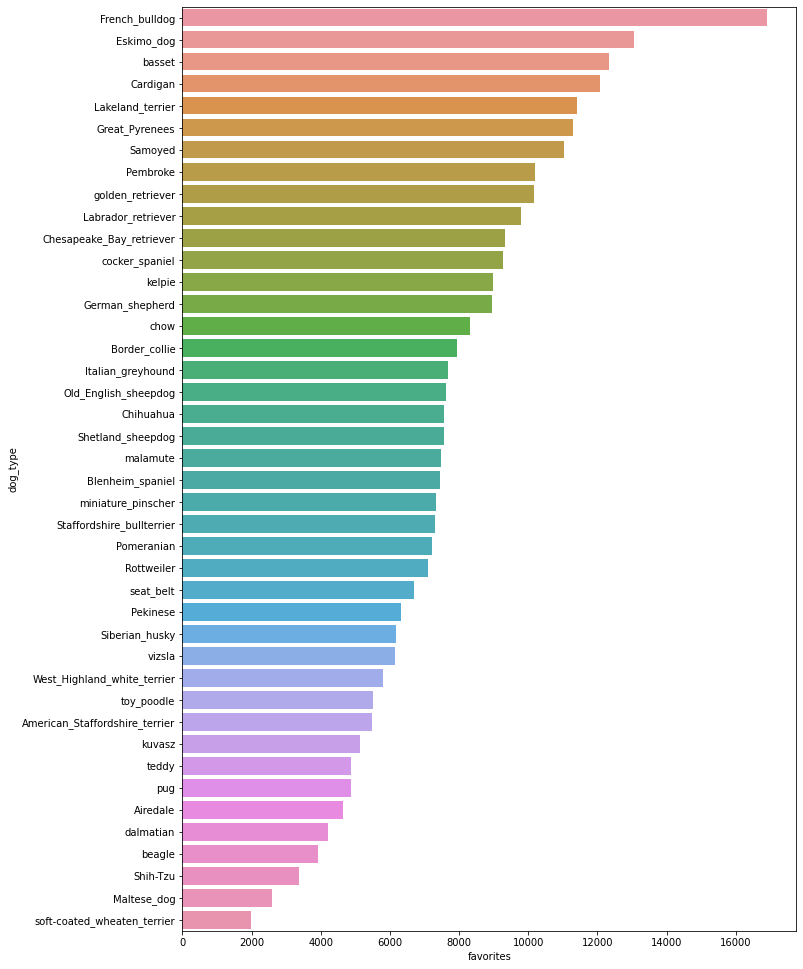

In [57]:
grouped = merged_df.groupby('dog_type').agg({'retweets': 'mean',
                                             'favorites': 'mean',
                                             'tweet_id': 'count'}).reset_index().sort_values('favorites', ascending=False)
fig,g = plt.subplots(figsize=(11,17))
g = sns.barplot(x=grouped[grouped['tweet_id']>10]['favorites'], y=grouped[grouped['tweet_id']>10]['dog_type'])
;

The top three dog types that were favorited the most were:
- French Bulldog
- Eskimo Dog
- Basset

Cardigan which was the 2nd most retweeted dog was the 4th most favorite dog. :(

''

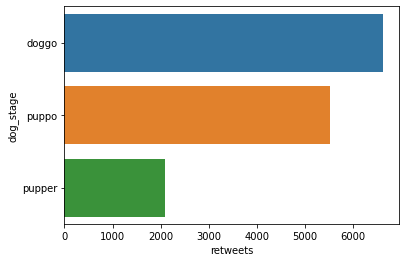

In [58]:
grouped = merged_df.groupby('dog_stage').agg({'retweets': 'mean',
                                             'favorites': 'mean',
                                             'tweet_id': 'count'}).reset_index().sort_values('retweets', ascending=False)
g = sns.barplot(x=grouped[grouped['tweet_id']>10]['retweets'], y=grouped[grouped['tweet_id']>10]['dog_stage'])
;

The most retweeted dog stage was when the dog was at doggo stage

''

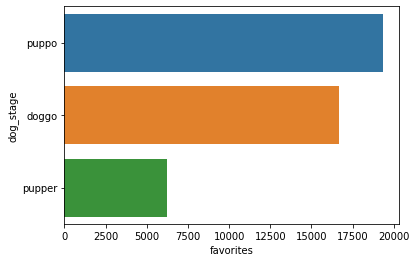

In [59]:
grouped = merged_df.groupby('dog_stage').agg({'retweets': 'mean',
                                             'favorites': 'mean',
                                             'tweet_id': 'count'}).reset_index().sort_values('favorites', ascending=False)
g = sns.barplot(x=grouped[grouped['tweet_id']>10]['favorites'], y=grouped[grouped['tweet_id']>10]['dog_stage'])
;

No prizes for the favorite dog stage. It had to be puppo